# Step 1] Find Contours of Bone Structure, Only Keep Bone Image

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (32, 16)

FILENAME = 'images/bone247_bse_image1.tif'

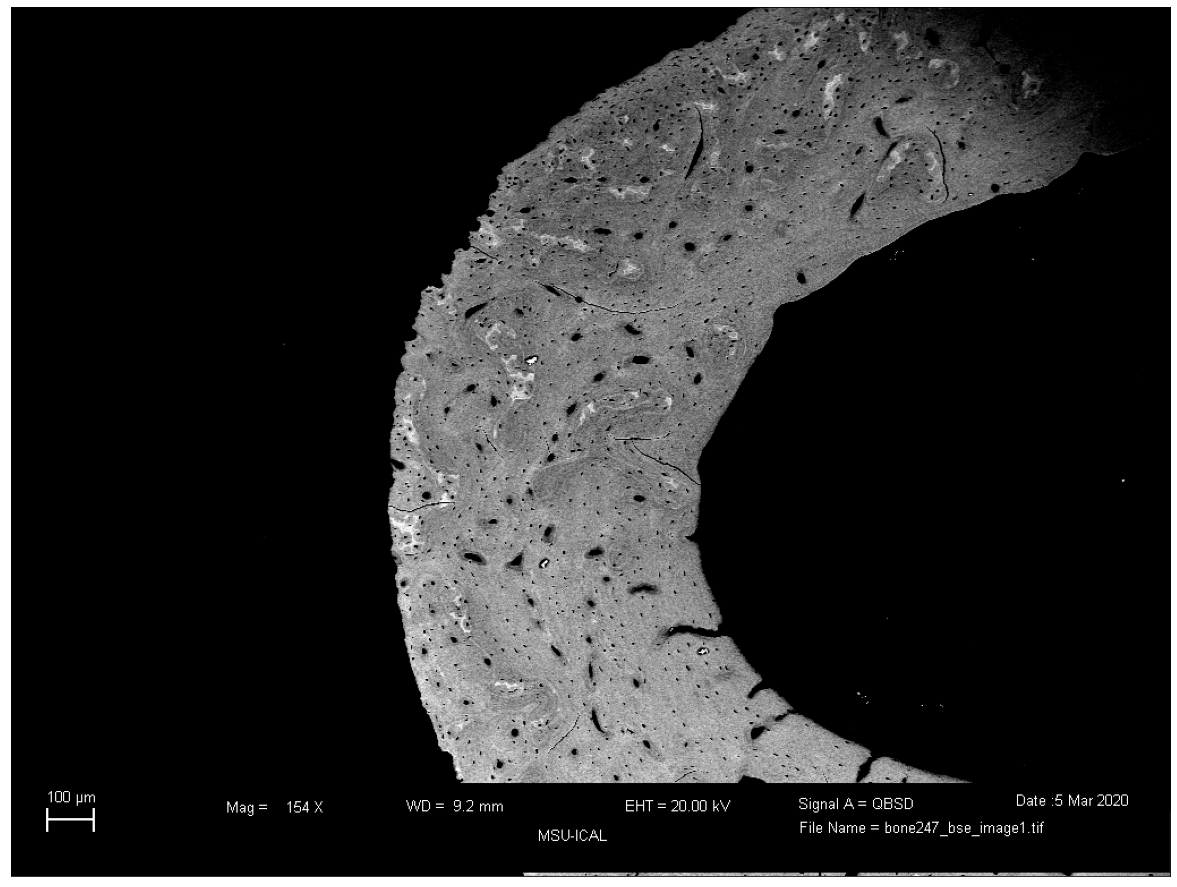

In [2]:
img = cv.imread(FILENAME, 0)

plt.imshow(img, cmap = 'gray')
plt.xticks([]), plt.yticks([])
plt.show()

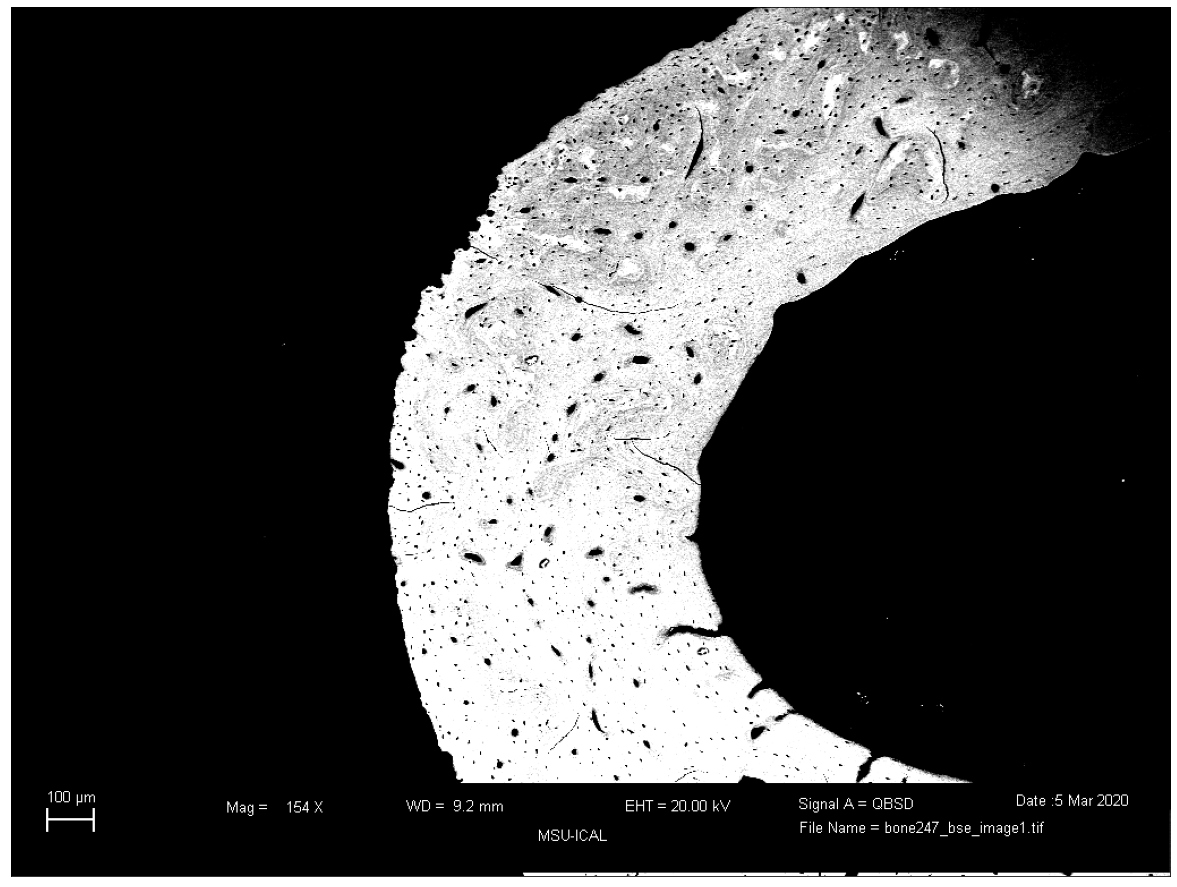

In [3]:
ret,truncd = cv.threshold(img,127,255,cv.THRESH_TRUNC)

plt.imshow(truncd, cmap = 'gray')
plt.xticks([]), plt.yticks([])
plt.show()

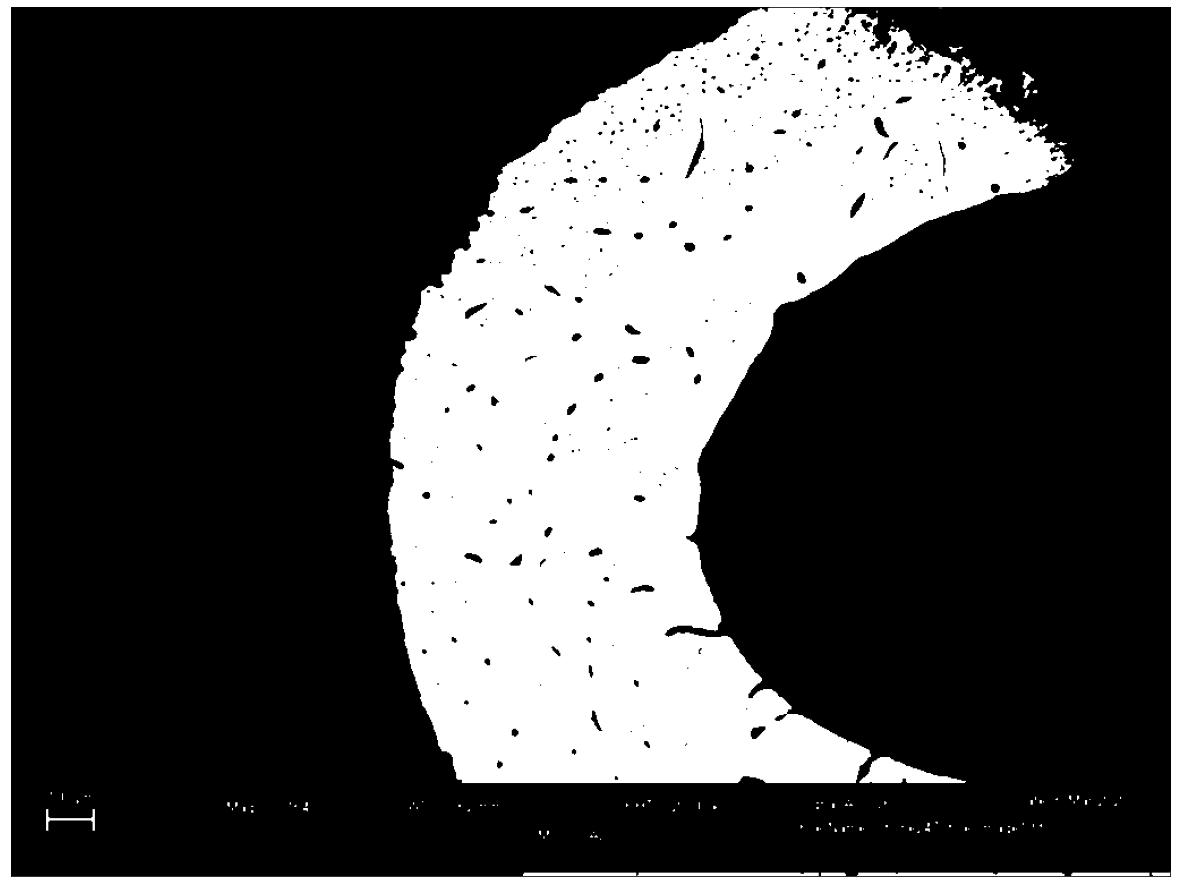

In [4]:
blur = cv.GaussianBlur(truncd,(5,5),0)
ret3,otsu = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

plt.imshow(otsu, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

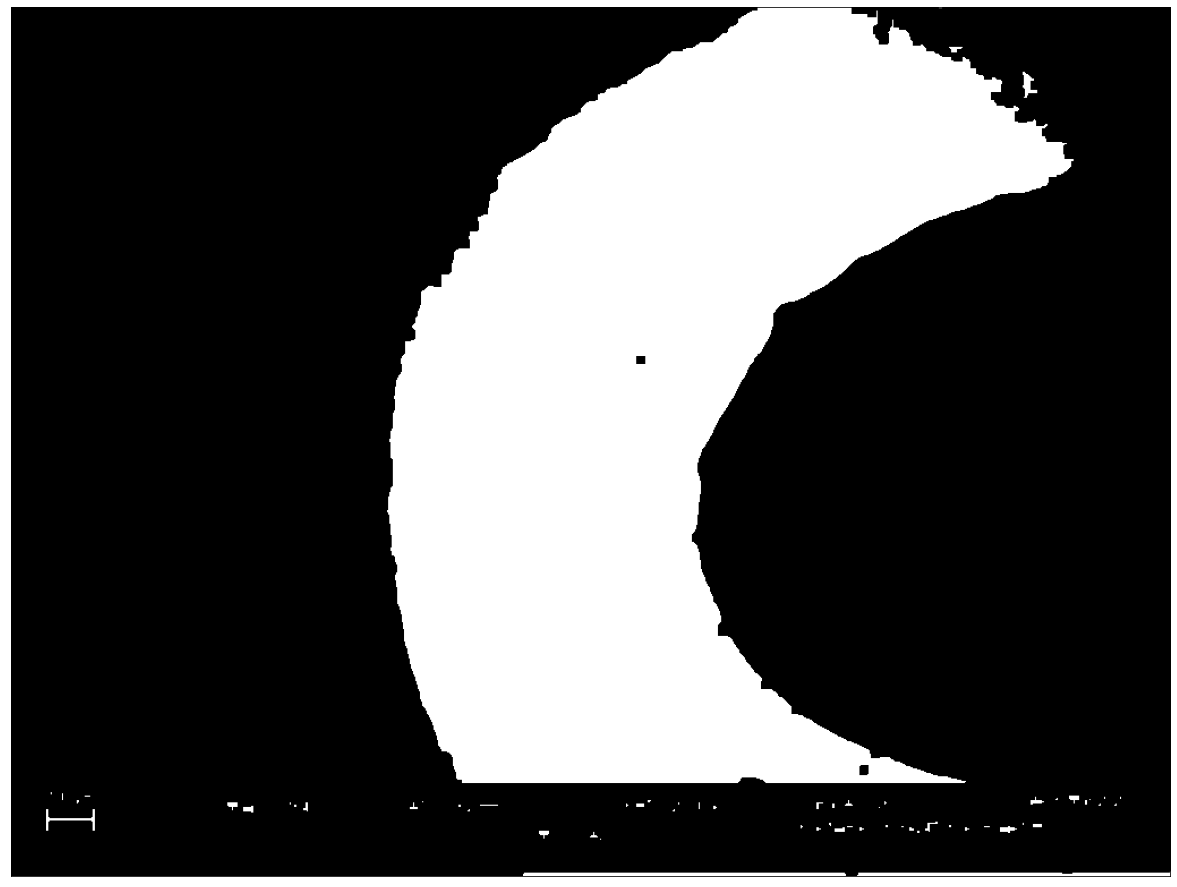

In [5]:
kernel = np.ones((7,7),np.uint8)
closing = cv.morphologyEx(otsu, cv.MORPH_CLOSE, kernel)

plt.imshow(closing, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

In [6]:
contours, hierarchy = cv.findContours(closing,
                                      cv.RETR_EXTERNAL,
                                      cv.CHAIN_APPROX_TC89_L1)

areas = [cv.contourArea(c) for c in contours]
max_index = np.argmax(areas)
print(max_index)

61


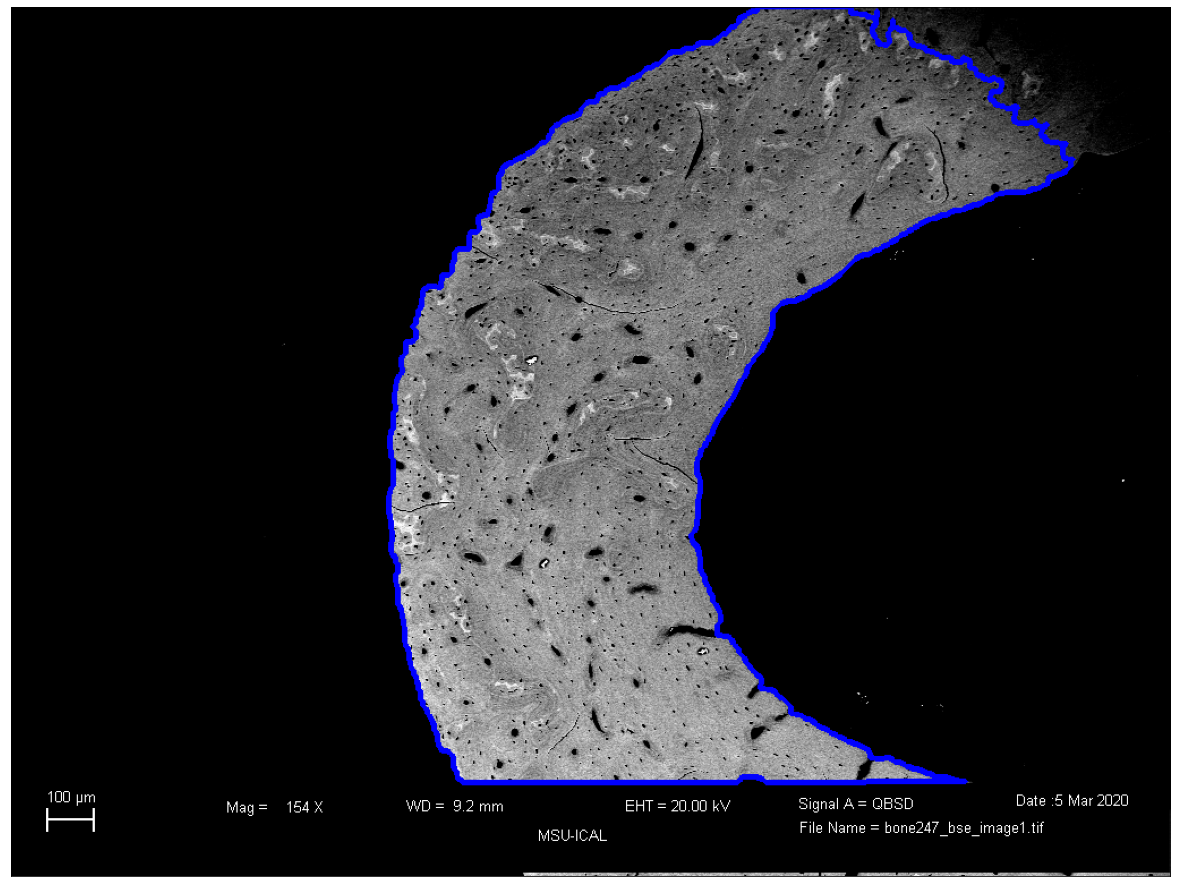

In [7]:
color_img = cv.imread(FILENAME)

out = cv.drawContours(color_img, contours, max_index, (0,0,255), 3)
plt.imshow(out)
plt.xticks([]), plt.yticks([])
plt.show()

# Step 2] Have Isolated Bone, Do Smoothing & Color Quantization, Sampling Proportion Approach

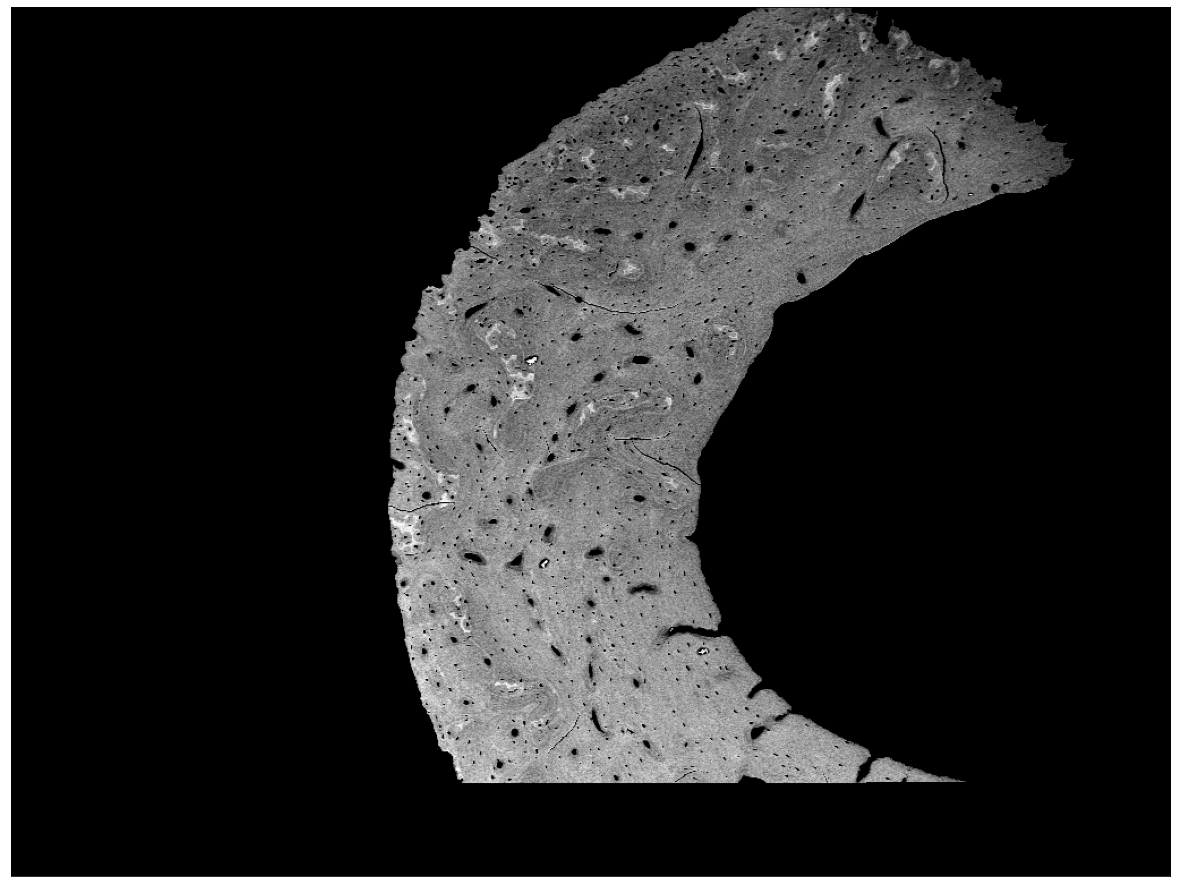

In [8]:
color_img = cv.imread(FILENAME)

bone = contours[max_index]

fill_color = [0,0,0]
mask_value = 255

stencil = np.zeros(color_img.shape[:-1]).astype(np.uint8)
cv.fillPoly(stencil, [bone], mask_value)

sel = (stencil != mask_value)
color_img[sel] = fill_color

BASE_IMG = color_img.copy()

plt.imshow(color_img)
plt.xticks([]), plt.yticks([])
plt.show()

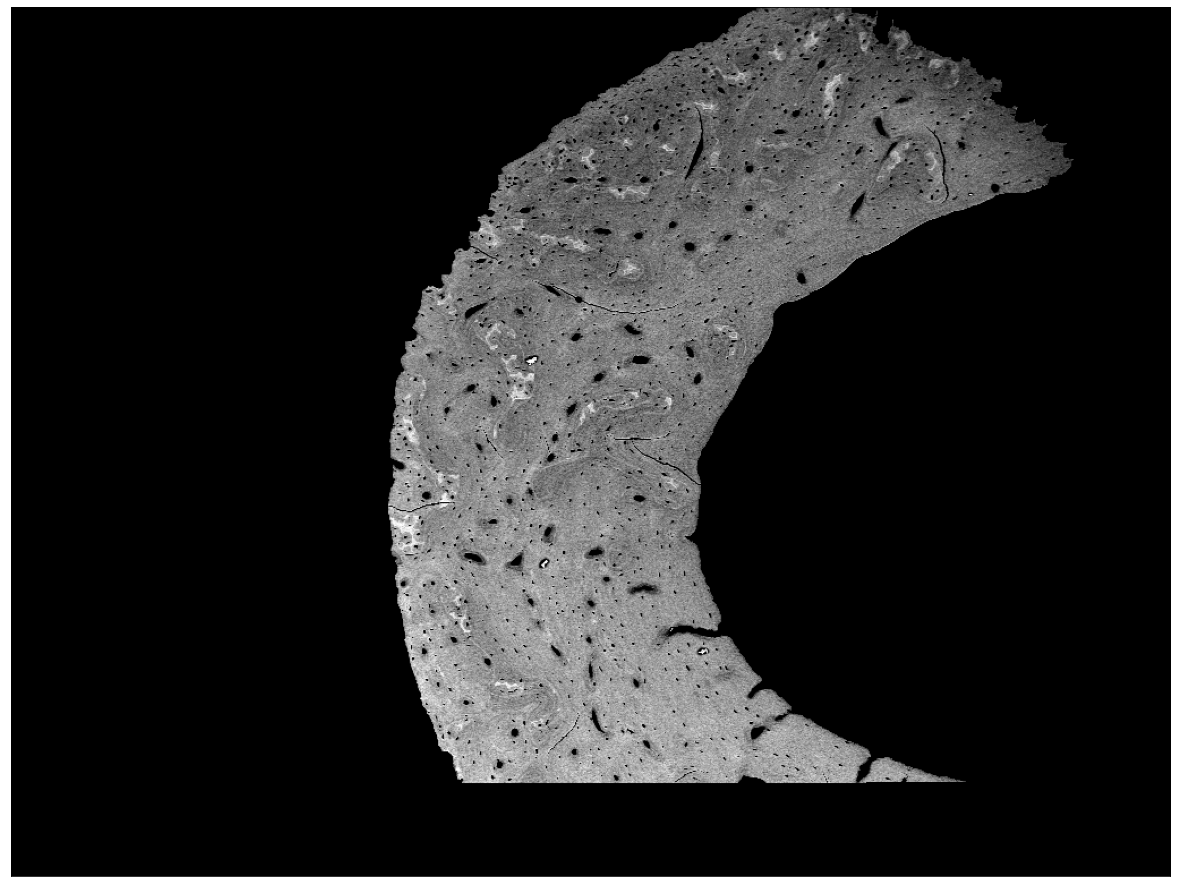

In [9]:
grayscale_filtered = cv.cvtColor(color_img, cv.COLOR_BGR2GRAY)

plt.imshow(grayscale_filtered, 'gray')
plt.xticks([]), plt.yticks([])
plt.show()

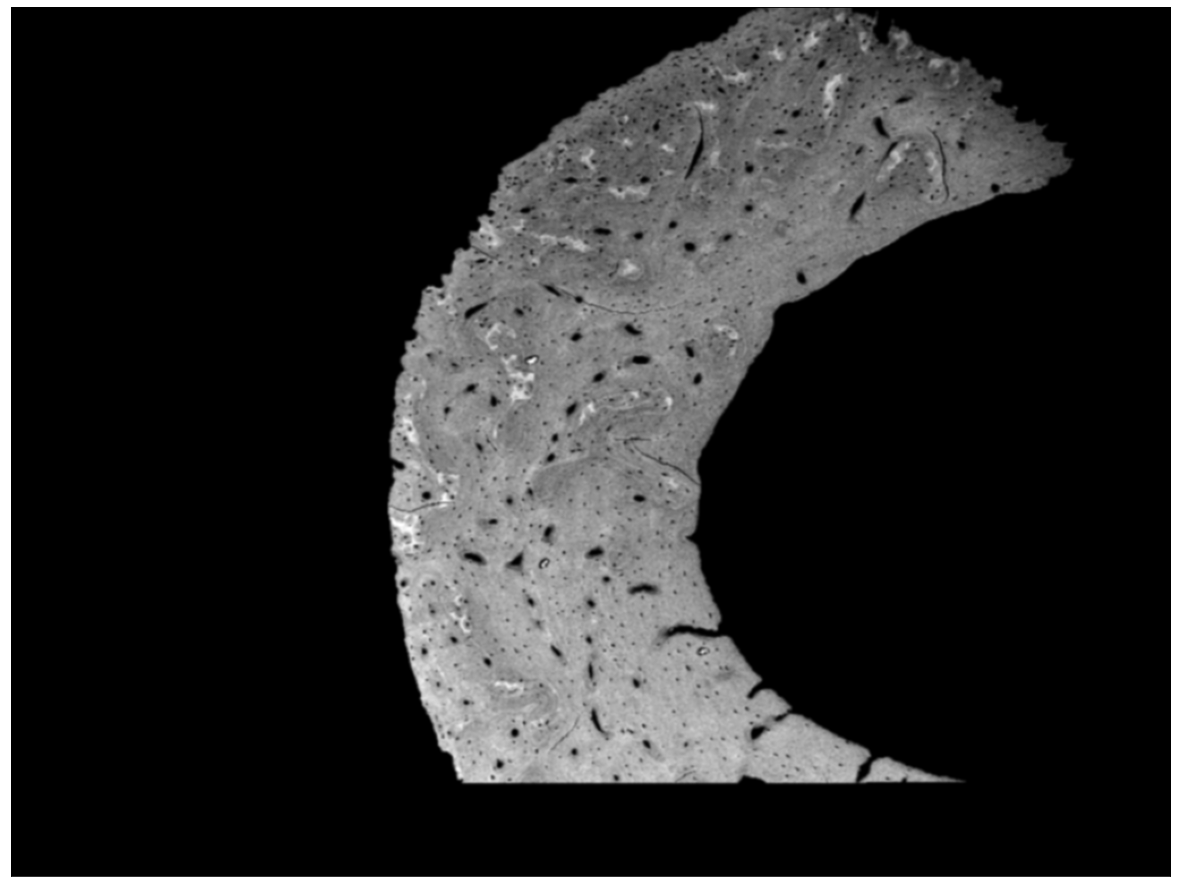

In [10]:
blur = cv.GaussianBlur(grayscale_filtered,(5,5),0)

plt.imshow(blur, 'gray')
plt.xticks([]),plt.yticks([])
plt.show()

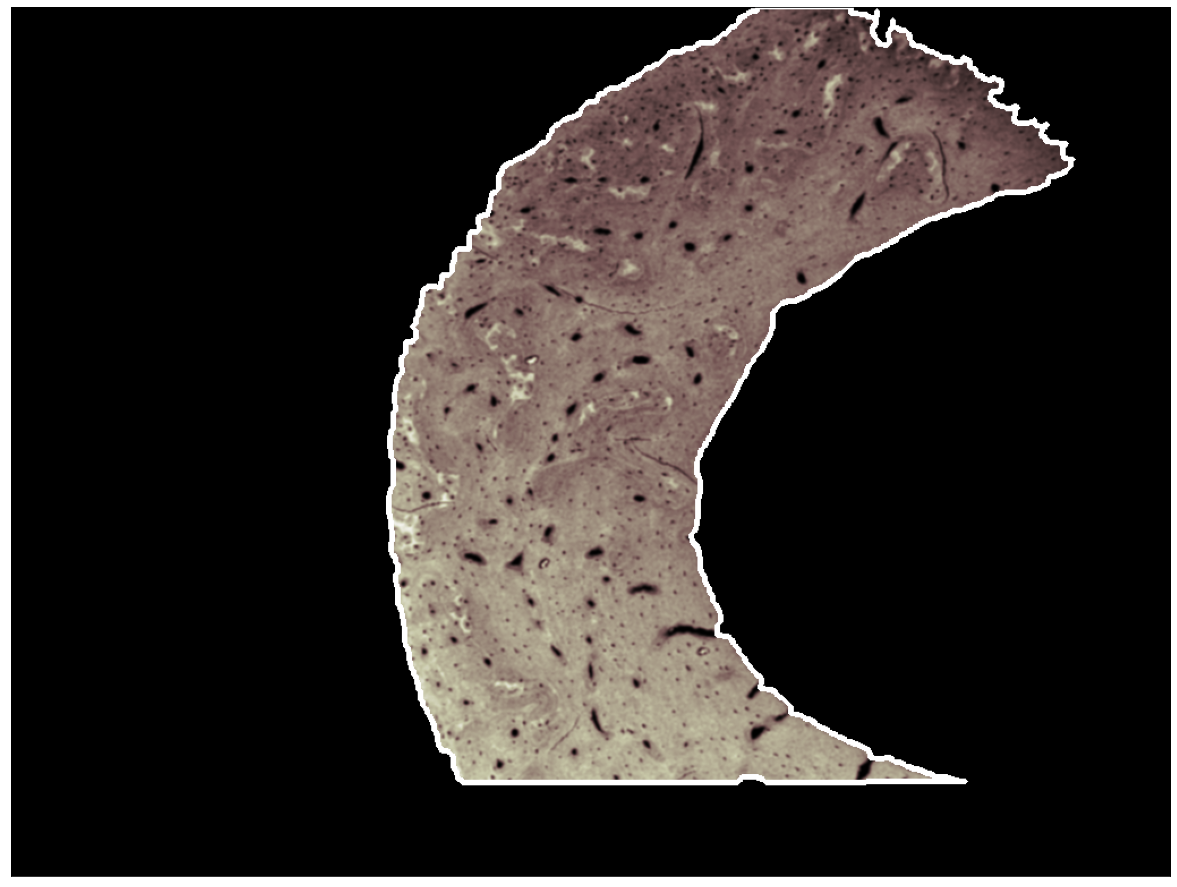

In [11]:
result = blur.copy()
heatmap = cv.applyColorMap(result, cv.COLORMAP_BONE)
out = heatmap.copy()
cv.drawContours(out, [bone], 0, (255,255,255), 3)

plt.imshow(out)
plt.xticks([]),plt.yticks([])
plt.show()

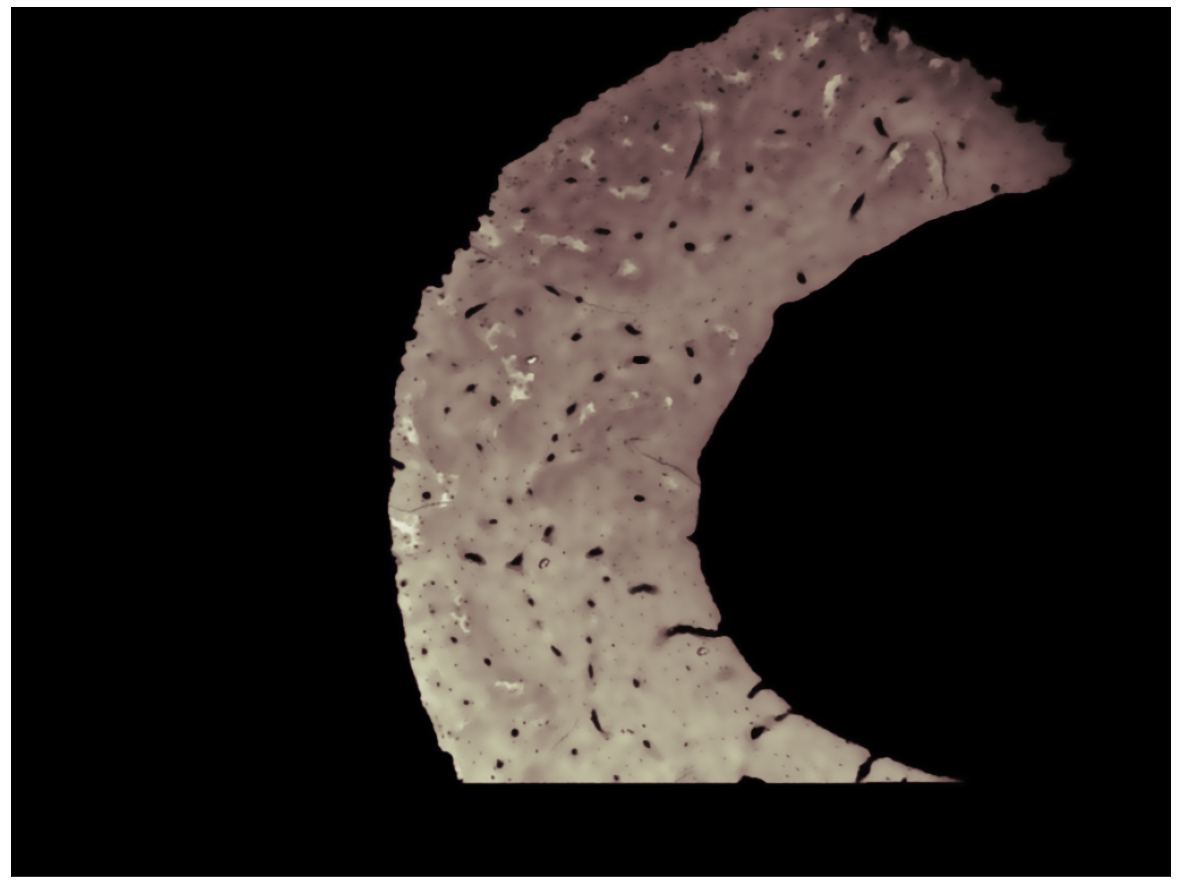

In [12]:
bilatblur = cv.bilateralFilter(heatmap, 13, 75, 75)

plt.imshow(bilatblur)
plt.xticks([]),plt.yticks([])
plt.show()

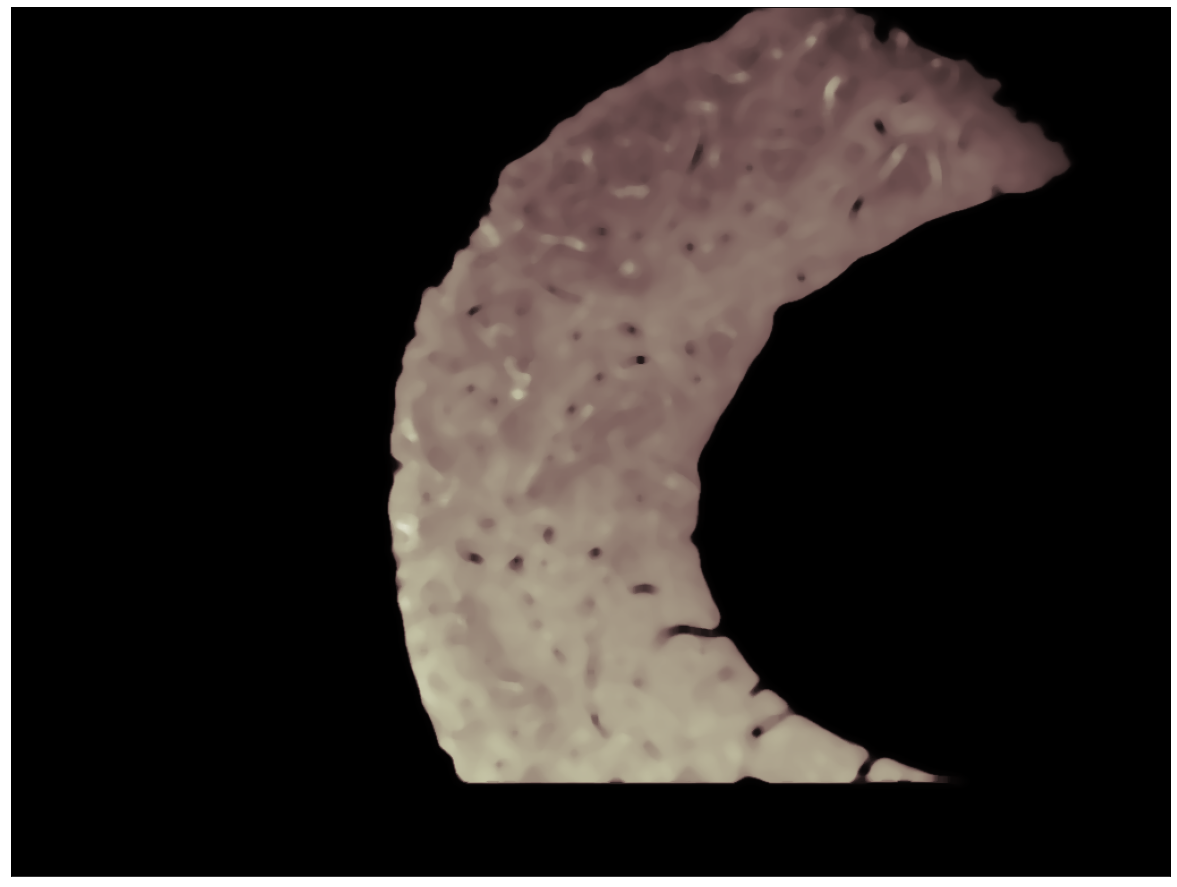

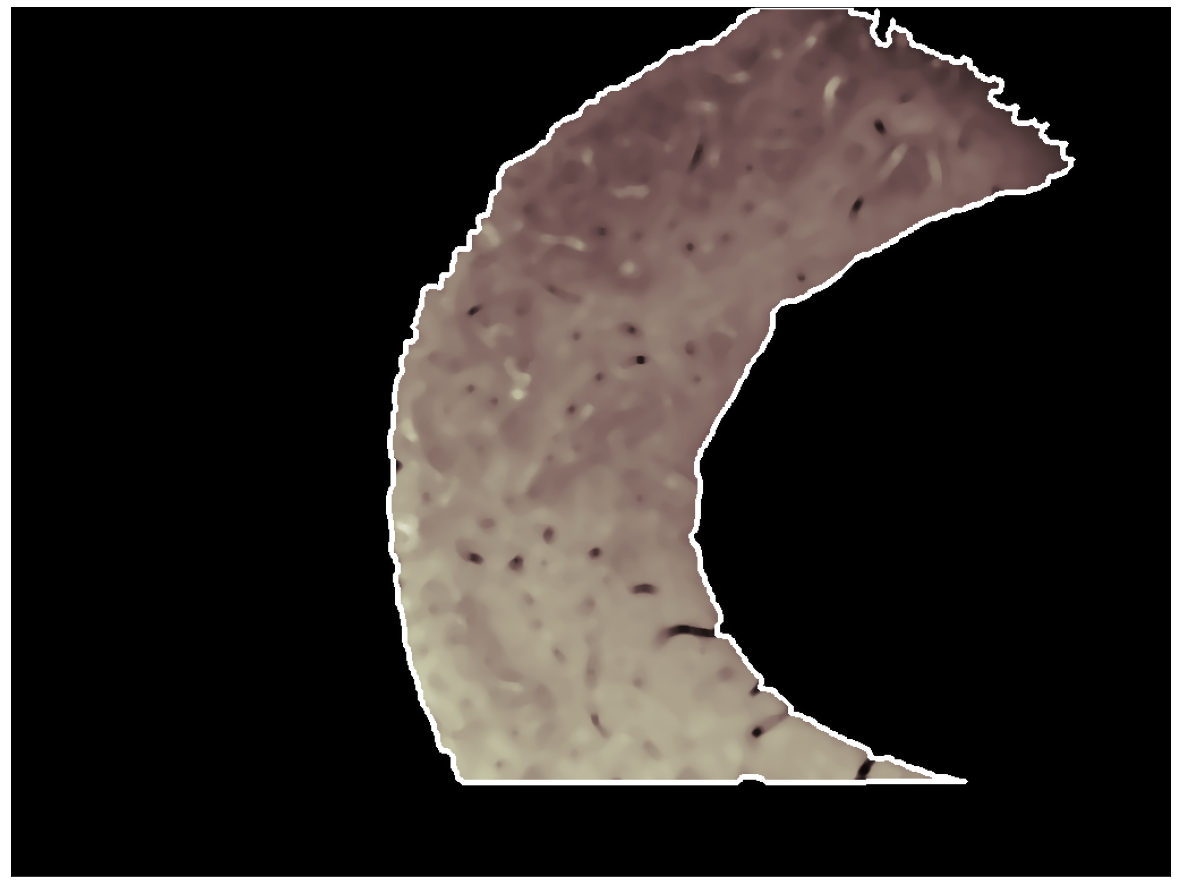

In [13]:
medblur = cv.medianBlur(bilatblur, 11)

plt.imshow(medblur)
plt.xticks([]),plt.yticks([])
plt.show()

out = medblur.copy()
cv.drawContours(out, [bone], 0, (255,255,255), 3)

plt.imshow(out)
plt.xticks([]),plt.yticks([])
plt.show()

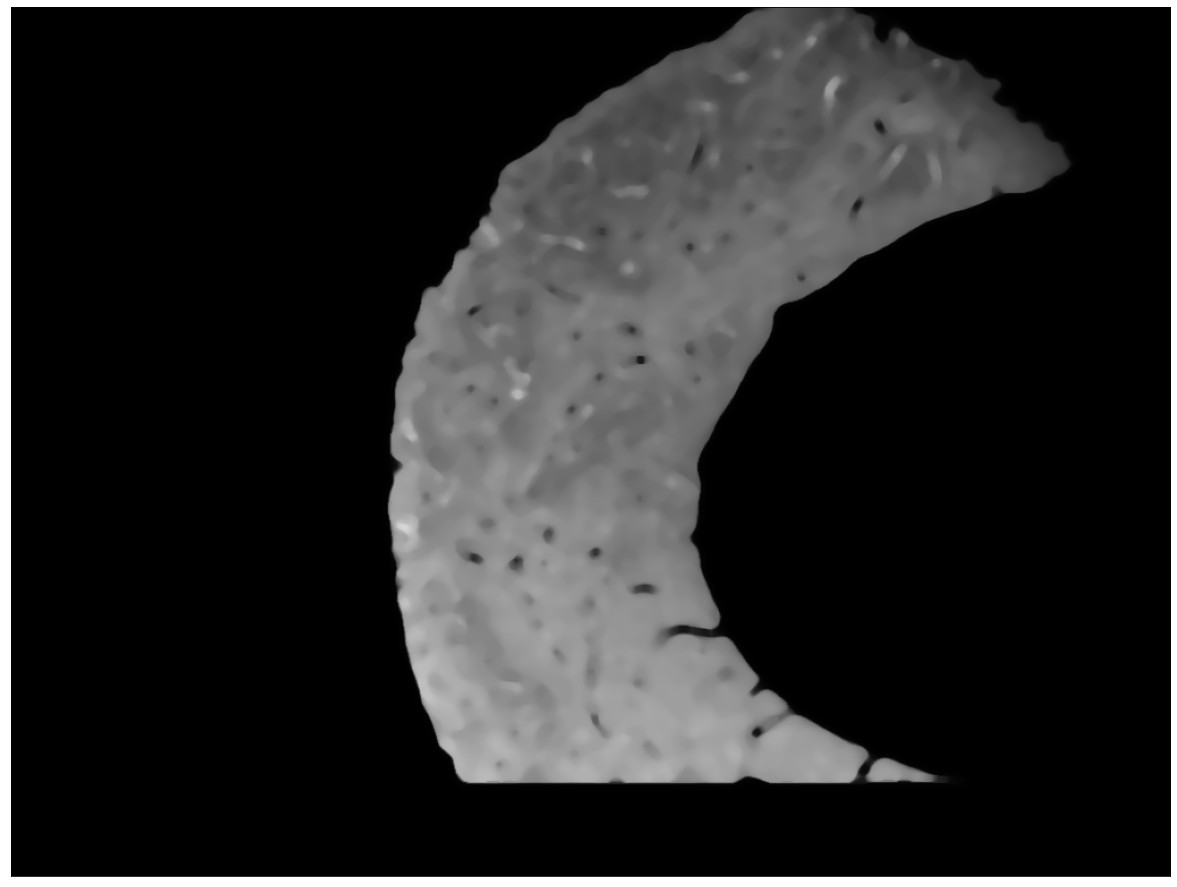

In [14]:
working_gray = medblur.copy()
working_gray = cv.cvtColor(working_gray, cv.COLOR_BGR2GRAY)
working_gray = cv.cvtColor(working_gray, cv.COLOR_BGR2RGB)

plt.imshow(working_gray, 'gray')
plt.xticks([]),plt.yticks([])
plt.show()

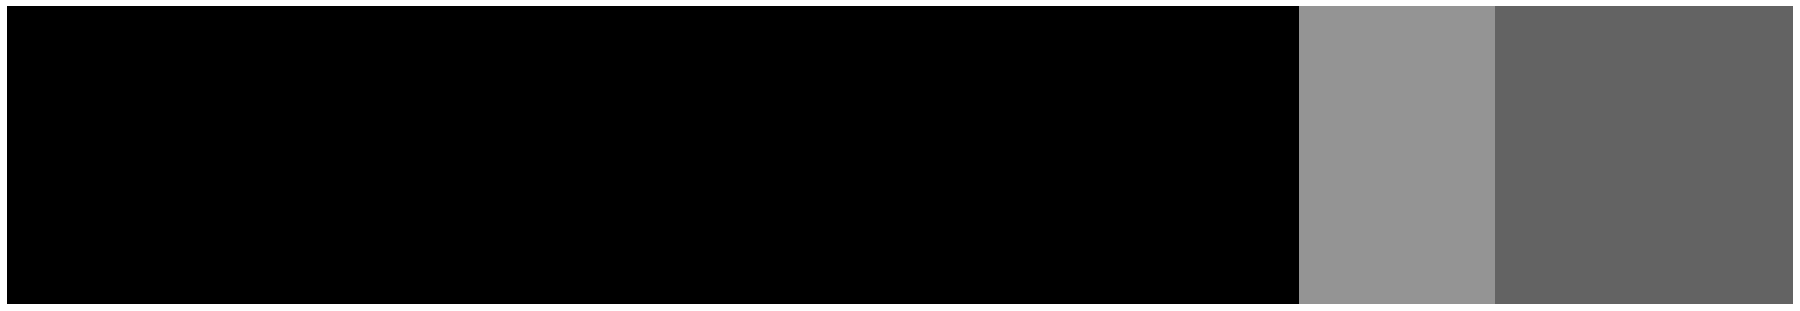

In [15]:
from sklearn.cluster import KMeans, MiniBatchKMeans

'''Do Color Quantization of input image, 
   map back to color percentage bar'''

## helper functions
def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    # return the histogram
    return hist


def plot_colors(hist, centroids):
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0
    # loop over the percentage of each cluster and the color of
    # each cluster
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv.rectangle(bar, (int(startX), 0), (int(endX), 50),
            color.astype("uint8").tolist(), -1)
        startX = endX
    
    # return the bar chart
    return bar


image = working_gray.copy()
image = image.reshape((image.shape[0] * image.shape[1], 3))

clt = MiniBatchKMeans(n_clusters=3)
clt.fit(image)

values = clt.cluster_centers_.squeeze()
## Get the label of each point
labels = clt.labels_
centroids = clt.cluster_centers_

# build a histogram of clusters and then create a figure
# representing the number of pixels labeled to each color
hist = centroid_histogram(clt)
bar = plot_colors(hist, clt.cluster_centers_)

# show our color bart
plt.figure()
plt.axis("off")
plt.imshow(bar)
plt.show()

In [16]:
ex = working_gray.copy()
print(np.shape(ex))

print(np.shape(image))
print(np.shape(clt.labels_))

## Figure out how to re-map back onto color image.
print(np.unique(labels))
print(centroids)

(768, 1024, 3)
(786432, 3)
(786432,)
[0 1 2]
[[  0.33117034   0.33117034   0.33117034]
 [148.8749004  148.8749004  148.8749004 ]
 [ 99.6078329   99.6078329   99.6078329 ]]


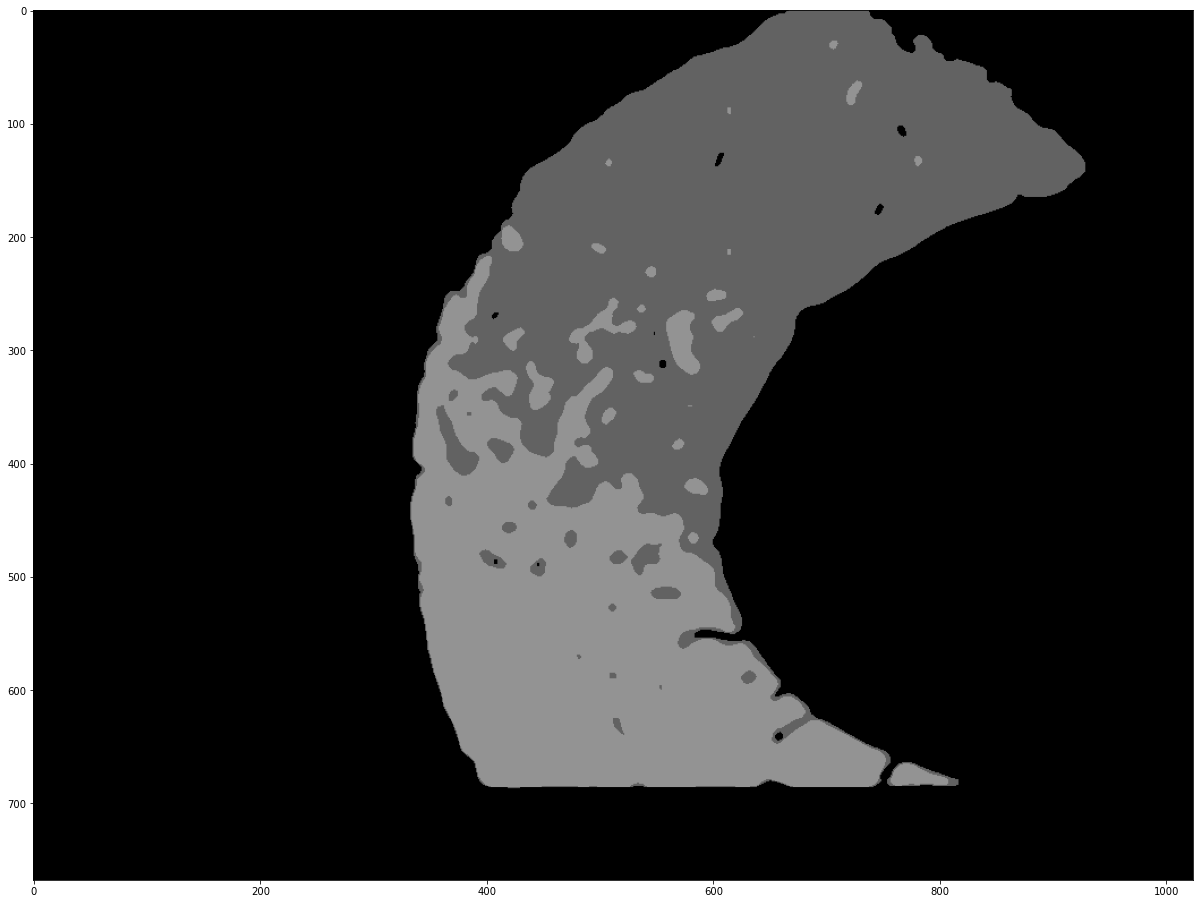

In [17]:
img = working_gray.copy()
Z = img.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER,
            10, 1.0)
K = 3
ret,label,center=cv.kmeans(Z,K,None,criteria,10,
                           cv.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

plt.imshow(res2)
plt.show()

# Instead of Color Quantization and Proportion Sampling, Try Doing Contour Areas

564 339


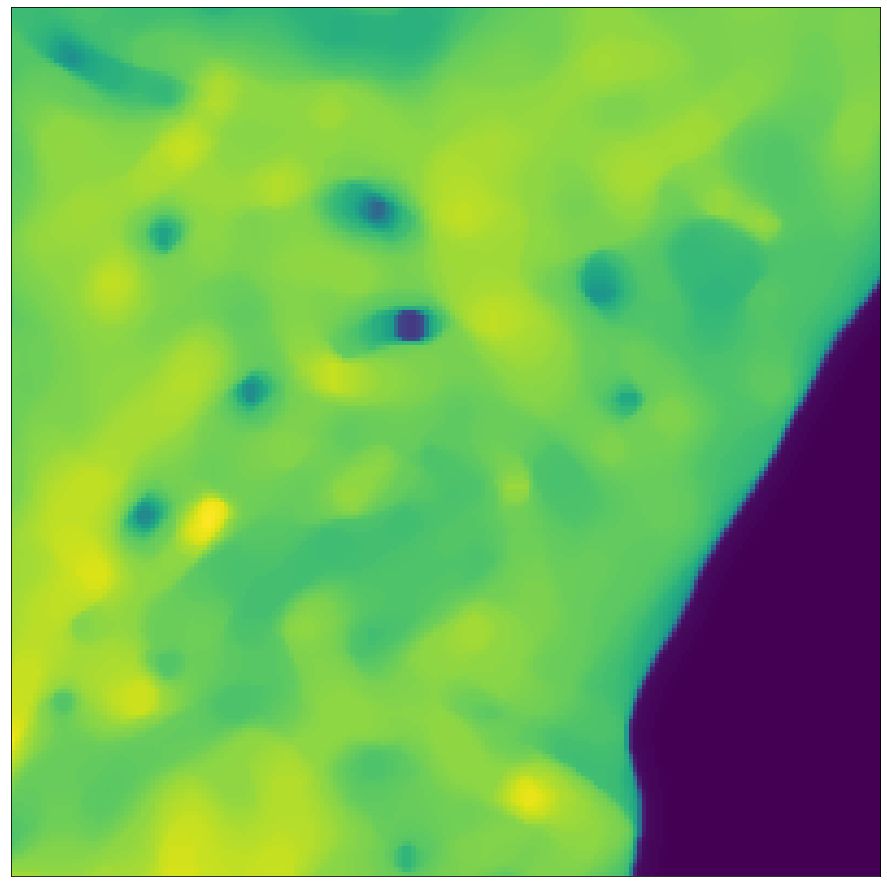

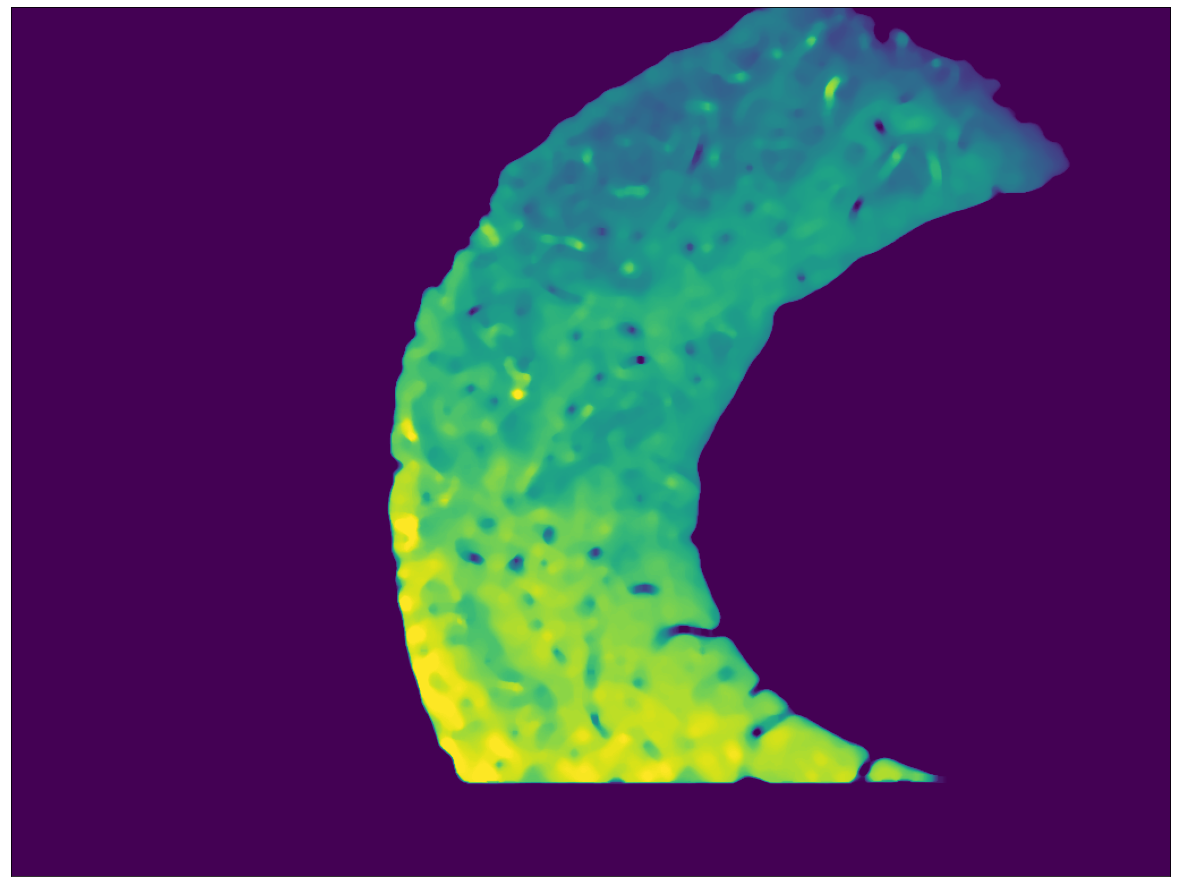

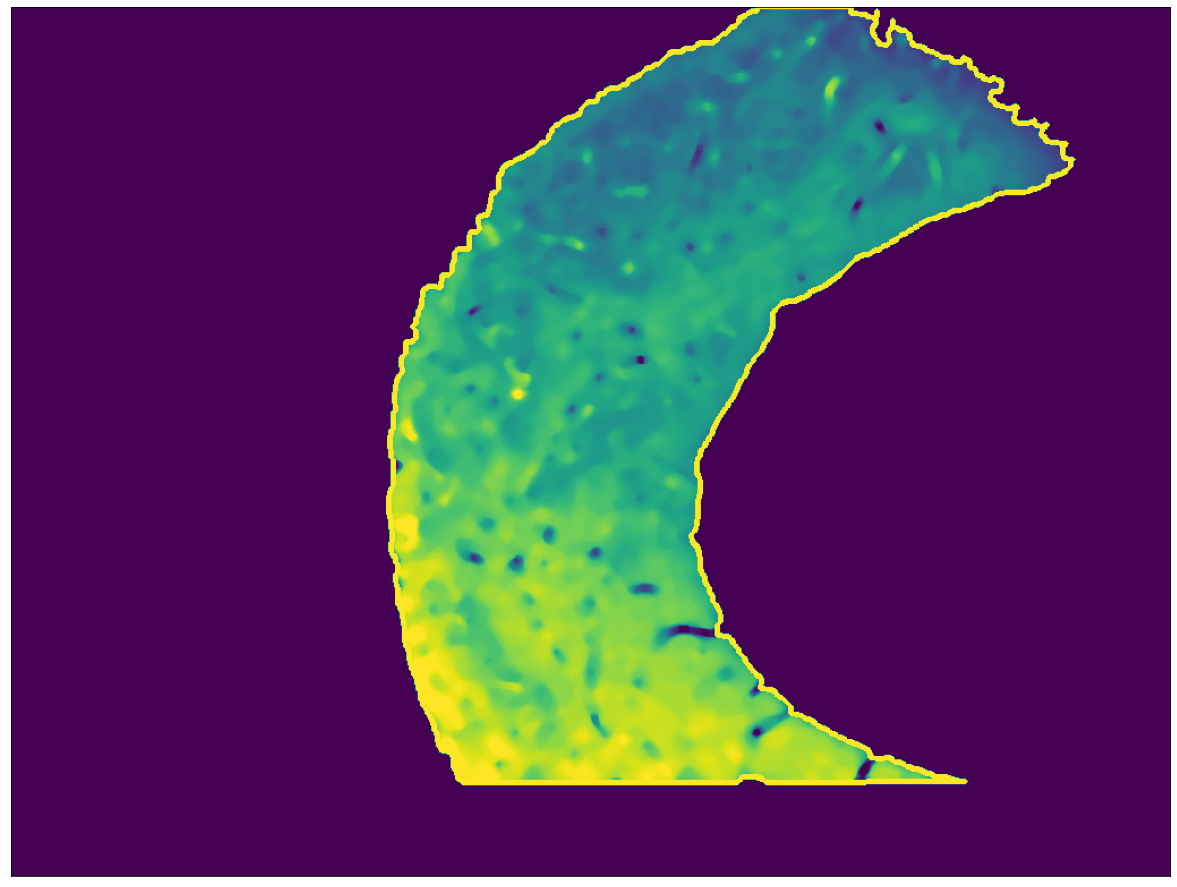

In [18]:
M = cv.moments(bone)
normalized = medblur.copy()
normalized = cv.cvtColor(normalized, cv.COLOR_BGR2GRAY)

cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

dx = 100
dy = 100

print(cx, cy)

ROI = normalized[cy-dy:cy+dy, cx-dx:cx+dx]

mean,STD = cv.meanStdDev(ROI)

offset = 1.96
clipped = np.clip(normalized, mean - offset*STD, mean + offset*STD)
clipped = clipped.astype(np.uint8)

result = cv.normalize(clipped, clipped, 0, 255, norm_type=cv.NORM_MINMAX)

plt.imshow(ROI)
plt.xticks([]),plt.yticks([])
plt.show()

plt.imshow(result)
plt.xticks([]),plt.yticks([])
plt.show()

out = result.copy()
cv.drawContours(out, [bone], 0, (255,255,255), 3)

plt.imshow(out)
plt.xticks([]),plt.yticks([])
plt.show()

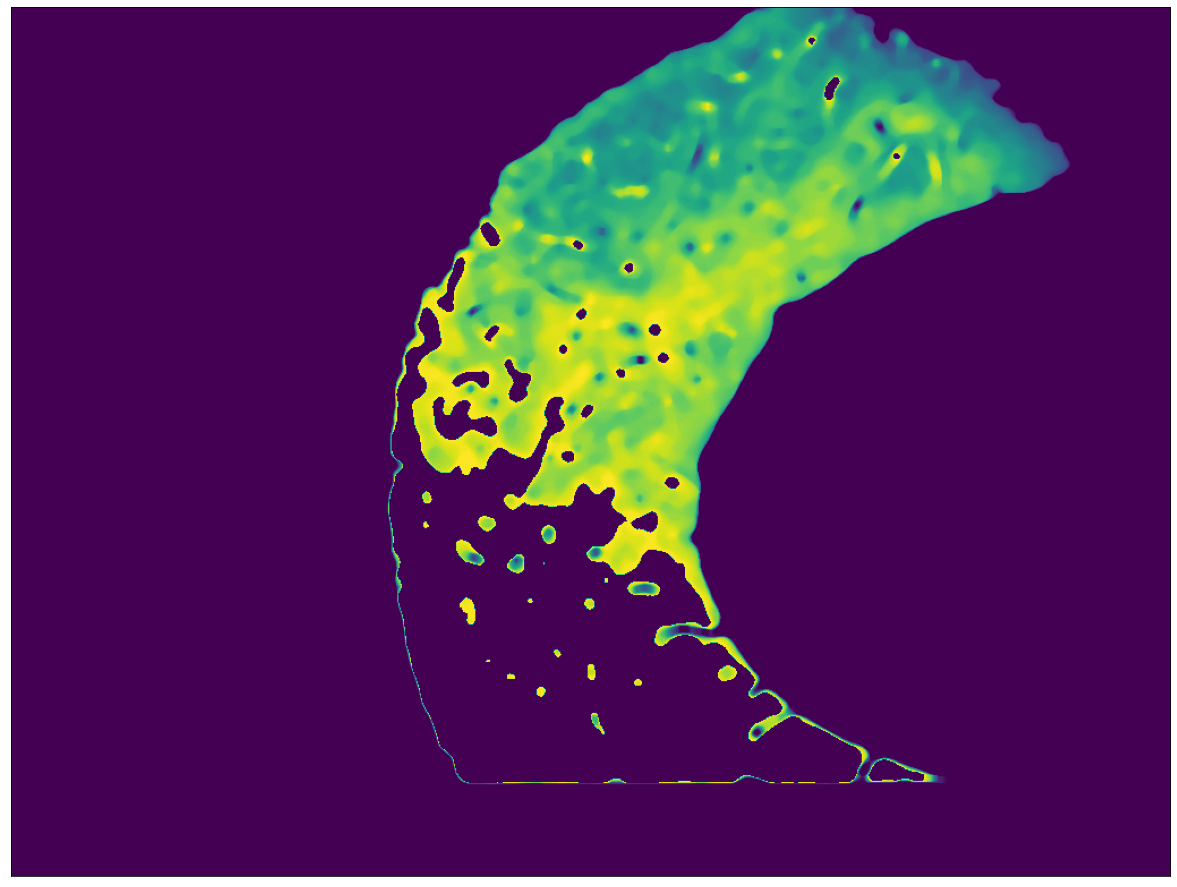

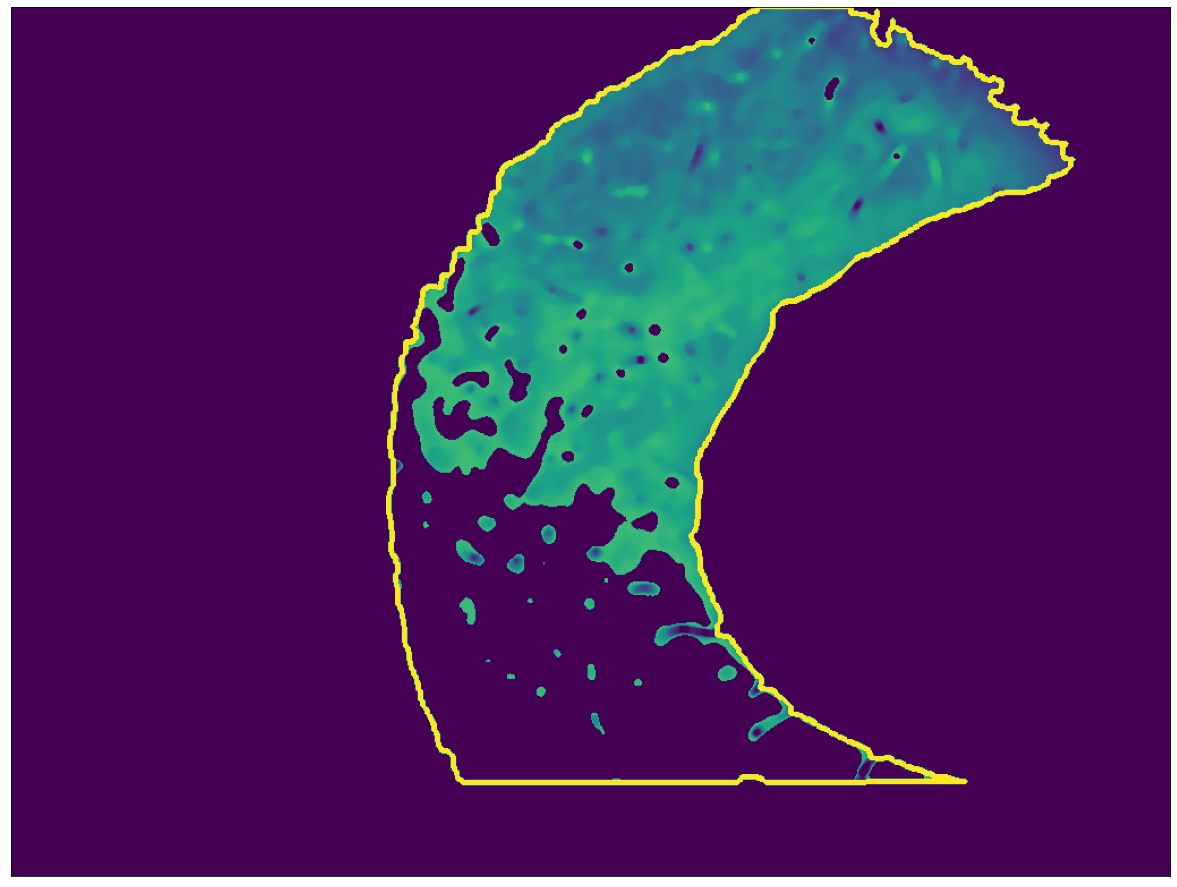

In [19]:
wat2 = result.copy()
ret,thresh4 = cv.threshold(wat2,mean+1.96*STD,255,cv.THRESH_TOZERO_INV)

plt.imshow(thresh4)
plt.xticks([]),plt.yticks([])
plt.show()

#cv.imwrite('non_lamellar_est.png', thresh4)

out = thresh4.copy()
cv.drawContours(out, [bone], 0, (255,255,255), 3)

plt.imshow(out)
plt.xticks([]),plt.yticks([])
plt.show()

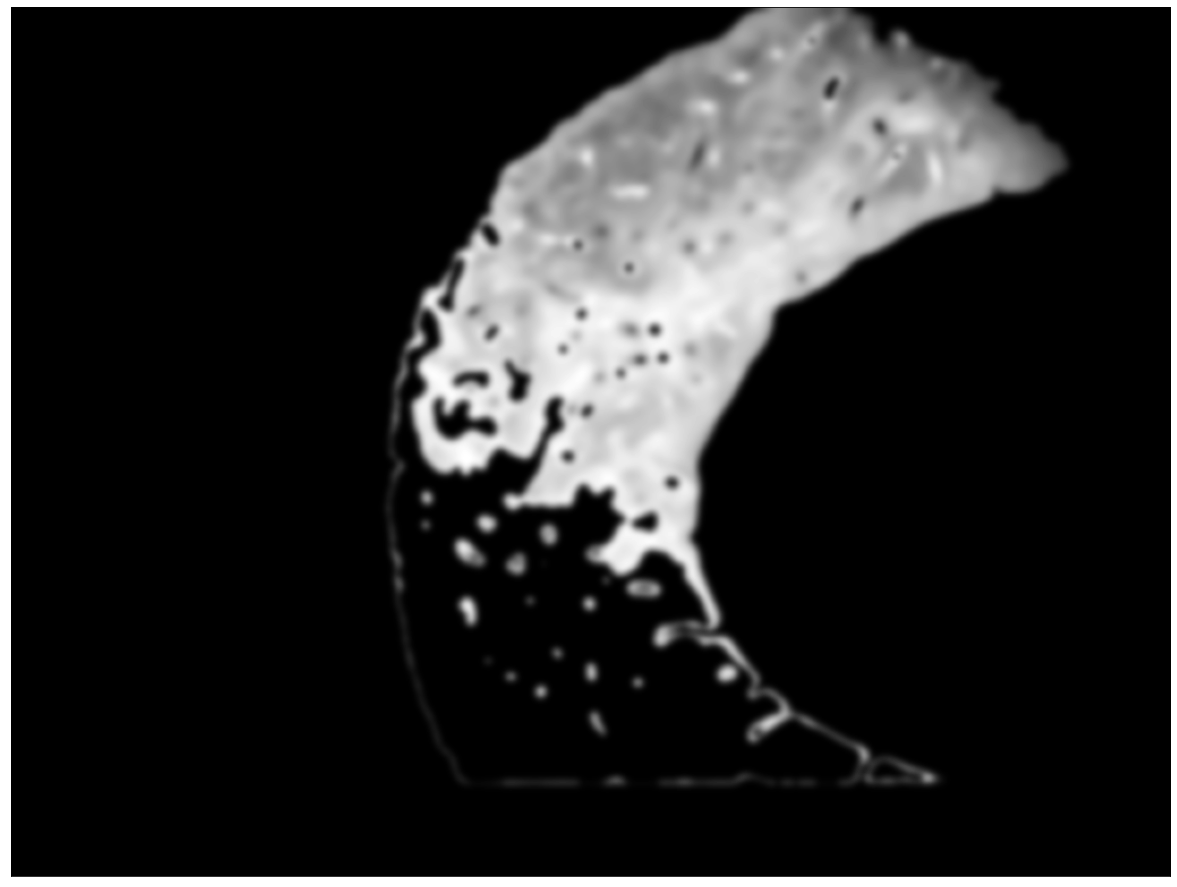

In [20]:
bluragain = cv.GaussianBlur(thresh4,(19,19),0)

plt.imshow(bluragain, 'gray')
plt.xticks([]),plt.yticks([])
plt.show()

0


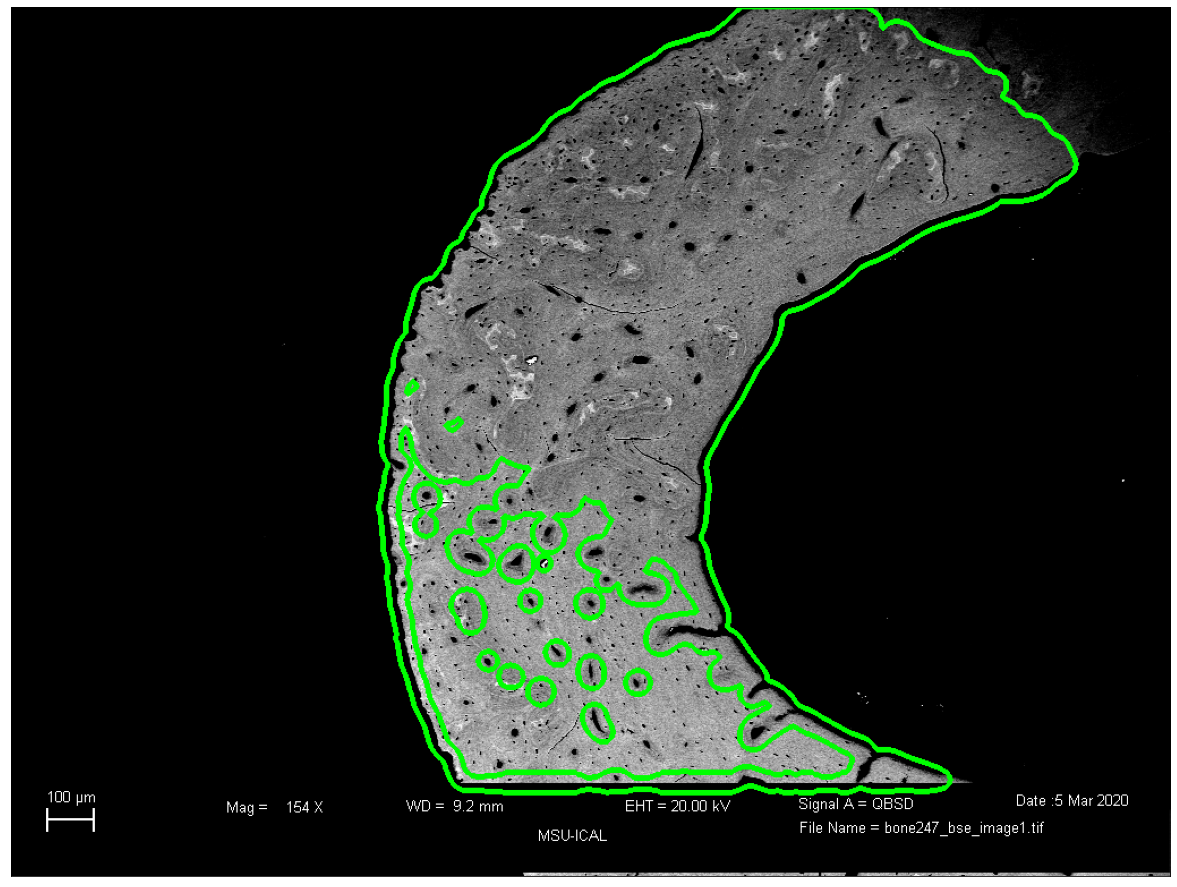

In [21]:
nonlamellar_contours, hierarchy = cv.findContours(bluragain,
                                             cv.RETR_TREE,
                                             cv.CHAIN_APPROX_SIMPLE)

areas = [cv.contourArea(c) for c in nonlamellar_contours]
max_index_nl = np.argmax(areas)
print(max_index_nl)

color_img = cv.imread(FILENAME)
out_img = color_img.copy()
cv.drawContours(out_img, nonlamellar_contours, -1, (0,255,0), 3)

plt.imshow(out_img, 'gray')
plt.xticks([]),plt.yticks([])
plt.show()

In [22]:
#from sklearn.feature_extraction import image
#from sklearn.cluster import spectral_clustering

#clustered = medblur.copy()
#clustered = cv.cvtColor(clustered, cv.COLOR_BGR2GRAY)
#mask = img.astype(bool)
#clustered = clustered.astype(float)

#graph = image.img_to_graph(clustered, mask=mask)
#graph.data = np.exp(-graph.data / graph.data.std())

#labels = spectral_clustering(graph, n_clusters=5, eigen_solver='arpack')
#label_im = np.full(mask.shape, -1.)
#label_im[mask] = labels

#plt.matshow(clustered)
#plt.matshow(label_im)

#plt.show()